In [1]:
import json
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
file1_path = 'my_spotify_data/Spotify Account Data/StreamingHistory_music_0.json'
# file2_path = 'my_spotify_data/Spotify Account Data/StreamingHistory_music_1.json'
# file3_path = 'my_spotify_data/Spotify Account Data/StreamingHistory_music_2.json'
# file4_path = 'my_spotify_data/Spotify Account Data/StreamingHistory_music_3.json'
# file5_path = 'my_spotify_data/Spotify Account Data/StreamingHistory_music_4.json'

def load_json_file(file_path): 
    encodings = ['utf-8', 'utf-8-sig', 'latin-1', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return json.load(file)
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"Unable to decode the file {file_path} with any of the attempted encodings.")
    
def combine_music_data(file1_path):
    data1 = load_json_file(file1_path)
    # data2 = load_json_file(file2_path)
    # data3 = load_json_file(file3_path)
    # data4 = load_json_file(file4_path)
    # data5 = load_json_file(file5_path)
    
    # Combine the data
    combined_data = data1
    
    # Convert to DataFrame
    df = pd.DataFrame(combined_data)
    
    # Convert 'endTime' to datetime and 'msPlayed' to timedelta
    df['endTime'] = pd.to_datetime(df['endTime'])
    df['duration'] = pd.to_timedelta(df['msPlayed'], unit='ms')
    
    # Drop the 'msPlayed' column as we now have 'duration'
    df = df.drop('msPlayed', axis=1)
    
    # Convert 'duration' to HH:MM:SS format
    df['duration'] = df['duration'].apply(lambda x: f"{int(x.total_seconds() // 3600):02d}:{int(x.total_seconds() % 3600 // 60):02d}:{int(x.total_seconds() % 60):02d}")
    
    # Sort by endTime
    df = df.sort_values('endTime')
    
    # Reset index
    df = df.reset_index(drop=True)
    
    return df

In [63]:
result_df = combine_music_data(file1_path)
result_df.to_csv('datasets/combined_music_data.csv', index=False, encoding='utf-8-sig')

# Analysis

In [76]:
df = pd.read_csv('datasets/combined_music_data.csv', parse_dates=['endTime'])

df.tail(10)

,endTime,artistName,trackName,duration
5111,2024-08-03 16:56:00,keshi,like i need u,00:03:02
5112,2024-08-03 16:59:00,HYBS,Dancing with my phone,00:03:23
5113,2024-08-03 17:02:00,J.Tajor,Like I Do,00:02:29
5114,2024-08-03 17:05:00,thủy,universe,00:03:06
5115,2024-08-03 17:08:00,The Millennial Club,feel the same,00:02:11
5116,2024-08-03 17:10:00,Devin Kennedy,Forget About You (Intimate),00:01:40
5117,2024-08-03 17:13:00,keshi,i swear i'll never leave again,00:02:53
5118,2024-08-03 17:16:00,JHIN,Blue Butterflies,00:02:17
5119,2024-08-03 17:20:00,HYBS,Killer,00:03:18
5120,2024-08-03 17:22:00,demxntia,keep smiling,00:02:12


# Time Spent Over Time

In [65]:
df_copy = df.copy()
def duration_to_hour(duration):
    h, m, s = map(int, duration.split(':'))
    return h + m / 60 + s / 3600

df_copy['duration_hours'] = df_copy['duration'].apply(duration_to_hour)
df_copy['cumulative_hours'] = df_copy['duration_hours'].cumsum()

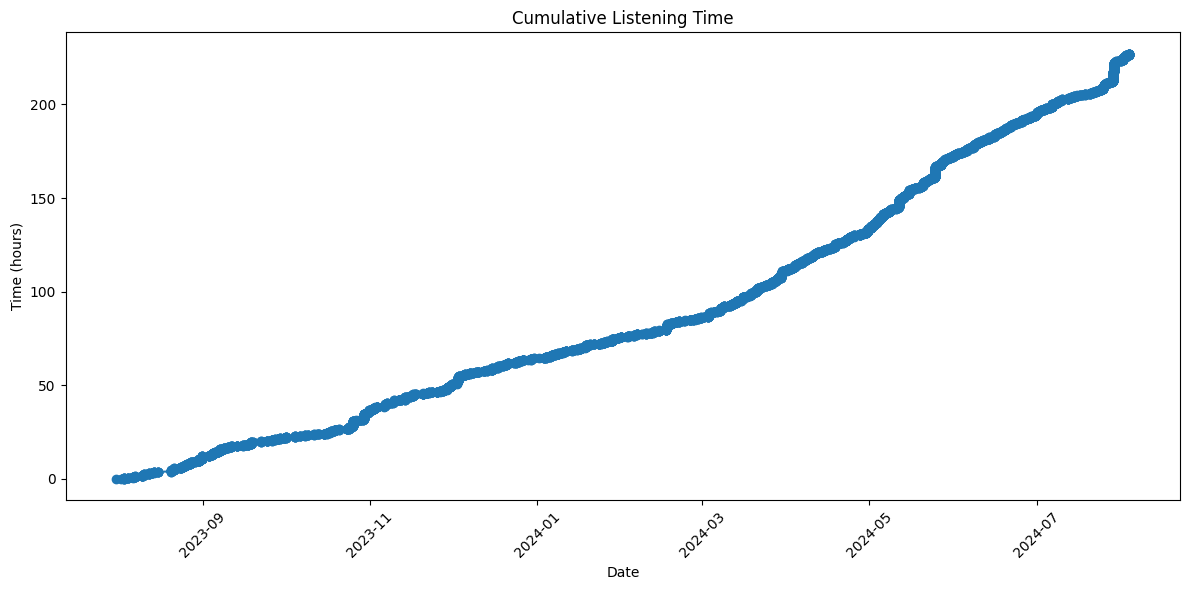

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(df_copy['endTime'], df_copy['cumulative_hours'], marker='o')
plt.title("Cumulative Listening Time")
plt.xlabel("Date")
plt.ylabel("Time (hours)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
# Print total listening time
total_hours = df_copy['duration_hours'].sum()
print(f"Total listening time: {total_hours:.2f} hours")

Total listening time: 227.16 hours


### Usage by Months

In [71]:
df_copy['month_year'] = df_copy['endTime'].dt.to_period('M')\
    
monthly_usage = df_copy.groupby('month_year')['duration_hours'].sum().reset_index()

monthly_usage = monthly_usage.sort_values('month_year')

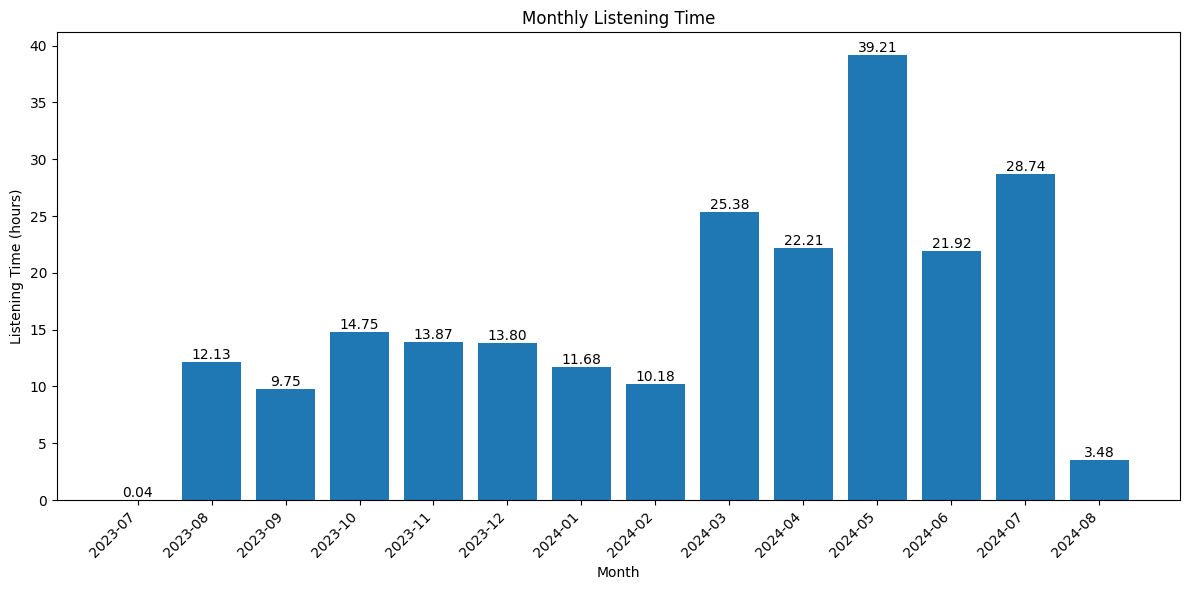

In [72]:
# Create the histogram
plt.figure(figsize=(12, 6))
plt.bar(monthly_usage['month_year'].astype(str), monthly_usage['duration_hours'])

plt.title("Monthly Listening Time")
plt.xlabel("Month")
plt.ylabel("Listening Time (hours)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of each bar
for i, v in enumerate(monthly_usage['duration_hours']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

In [73]:
# Print average monthly listening time
avg_monthly_hours = monthly_usage['duration_hours'].mean()
print(f"Average monthly listening time: {avg_monthly_hours:.2f} hours")

Average monthly listening time: 16.23 hours


# Track Counts Over Time

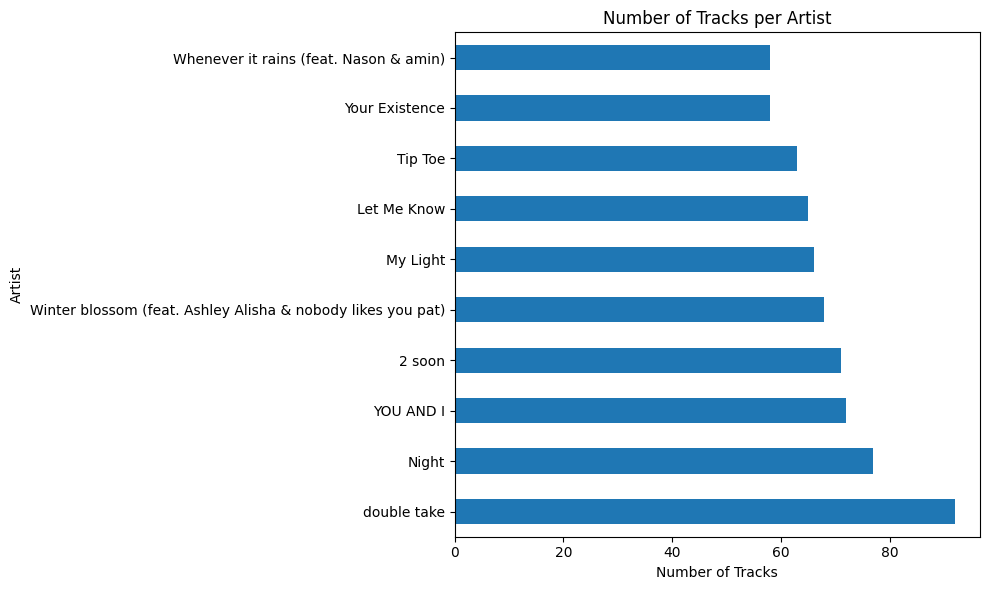

In [74]:
track_counts = df['trackName'].value_counts()

top_10_tracks = track_counts.head(10)
# Create a bar chart
plt.figure(figsize=(10, 6))
top_10_tracks.plot(kind='barh')
plt.title('Number of Tracks per Artist')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.tight_layout()

# Show the plot
plt.show()

In [75]:
print(top_10_tracks)

trackName
double take                                                    92
Night                                                          77
YOU AND I                                                      72
2 soon                                                         71
Winter blossom (feat. Ashley Alisha & nobody likes you pat)    68
My Light                                                       66
Let Me Know                                                    65
Tip Toe                                                        63
Your Existence                                                 58
Whenever it rains (feat. Nason & amin)                         58
Name: count, dtype: int64


# Top Tracks Total Listening Time

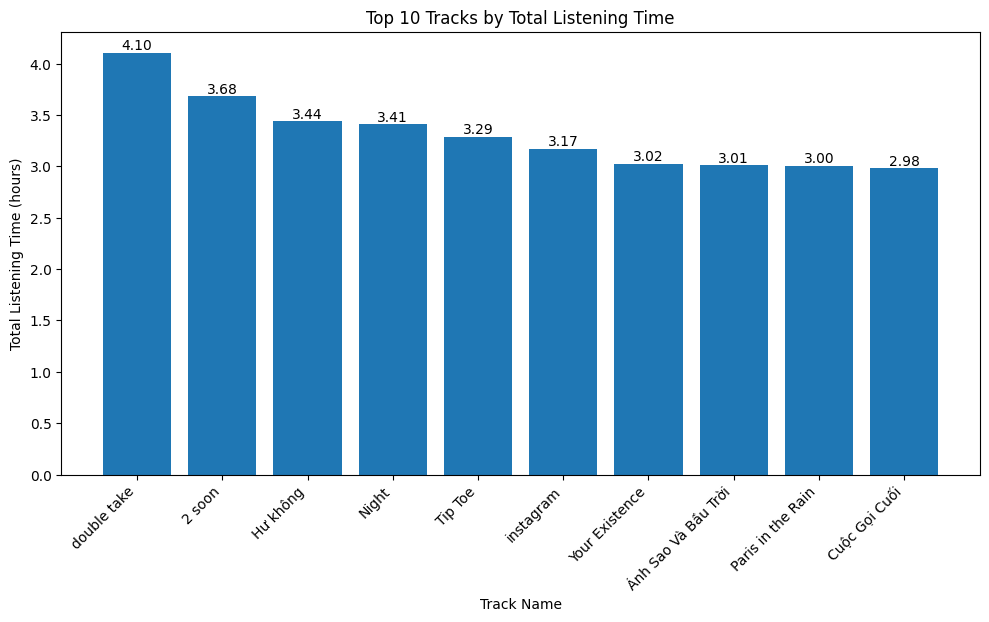

In [80]:
track_usage = df_copy.groupby('trackName')['duration_hours'].sum().reset_index()
top_10_tracks = track_usage.sort_values('duration_hours', ascending=False).head(10)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_tracks['trackName'], top_10_tracks['duration_hours'])

plt.title("Top 10 Tracks by Total Listening Time")
plt.xlabel("Track Name")
plt.ylabel("Total Listening Time (hours)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.subplots_adjust(bottom=0.2)

plt.show()

In [83]:
# Print total listening time for top 10 tracks
total_top_10 = top_10_tracks['duration_hours'].sum()
print(f"Total listening time for top 10 tracks: {total_top_10:.2f} hours")

# Print percentage of total listening time
total_all = df_copy['duration_hours'].sum()
percentage = (total_top_10 / total_all) * 100
print(f"This represents {percentage:.2f}% of your total listening time")

Total listening time for top 10 tracks: 33.10 hours
This represents 14.57% of your total listening time


# Specific Track Listening Time

In [86]:
# Function to get listening time for a specific track
def get_track_listening_time(track_name):
    track_time = track_usage[track_usage['trackName'] == track_name]['duration_hours'].values
    if len(track_time) > 0:
        return f"Total listening time for '{track_name}': {track_time[0]:.2f} hours"
    else:
        return f"Track '{track_name}' not found in the dataset"

# Example usage:
print(get_track_listening_time("Like I Do"))  # Replace with any track name you want to check
print(get_track_listening_time("Your Existence"))    # Another example

Total listening time for 'Like I Do': 0.33 hours
Total listening time for 'Your Existence': 3.02 hours
